### Before starting this notebook, create netcdf files using `save2nc.py`

This is because somehow UC2 cannot load values from google cloud.

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import os

In [2]:
#ERA5
ds = xr.open_dataset('data/era5/dynamics_850.nc')

#calculate horizontal wind speed
swnd = np.sqrt(ds['u850']**2 + ds['v850']**2)

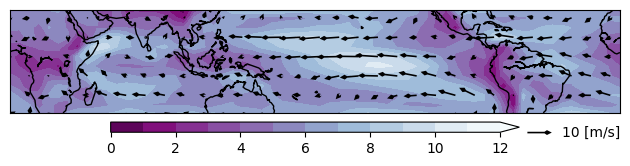

In [3]:
#plot it using Basemap
#if you do not have basemap installed,
#> pip install basemap
from mpl_toolkits.basemap import Basemap
map = Basemap(projection='cyl',llcrnrlat= -30,urcrnrlat=30,
              resolution='c',  llcrnrlon=ds.longitude[0],urcrnrlon=ds.longitude[-1])

map.drawcoastlines()
xx, yy = map(*np.meshgrid(ds.longitude,ds.latitude))

#wind speed (contourf)
im = map.contourf(xx, yy, swnd.mean('time').transpose(), np.arange(13), extend='max', cmap='BuPu_r')
plt.colorbar(im, orientation='horizontal', pad=0.02, aspect=40, shrink=0.67)

#wind vector
uvector = ds['u850'].mean('time')
vvector = ds['v850'].mean('time')

q = plt.quiver(ds.longitude[::2], ds.latitude[::2],
               uvector.transpose()[::2,::2], vvector.transpose()[::2,::2],
               headlength=3, scale=250, color='black')
qk=plt.quiverkey(q, 0.87, 0.15, 10, '10 [m/s]',
                 labelpos='E', coordinates='figure')

plt.tight_layout()

Here we plot the wind speed and wind vectors at 850 hPa, averaged over 2020, using ERA5.

Now how would this differ between ERA5 and other weather prediction models? 

In [4]:
#list of folders (weather predition models)
odirs = [od for od in os.listdir("data")]
odirs

['fuxi',
 'keisler',
 'era5',
 'graphcast',
 'pangu',
 'neuralgcm_deterministic',
 'hres',
 'sphericalcnn']

In [5]:
#I want era5 and hres to be listed in the first elements.
odirs.remove('era5')
odirs.remove('hres')

odirs.insert(0, 'era5')
odirs.insert(1, 'hres')

odirs

['era5',
 'hres',
 'fuxi',
 'keisler',
 'graphcast',
 'pangu',
 'neuralgcm_deterministic',
 'sphericalcnn']

In [6]:
#As we calculate the wind speed and plot it for every individual model,
#I'd do some lazy ass movement.

#calculate wind speed
def cal_wspeed(u, v):
    return np.sqrt(u**2 + v**2)

#mapping over the tropics
def map_tropics(axs, var, lat, lon, **kwargs):
    map = Basemap(projection='cyl',llcrnrlat= -30,urcrnrlat=30,
                  resolution='c',  llcrnrlon=lon[0],urcrnrlon=lon[-1], ax=axs)

    map.drawcoastlines()
    xx, yy = map(*np.meshgrid(lon,lat))

    #surface wind
    im = map.contourf(xx, yy, var, **kwargs)
    return im

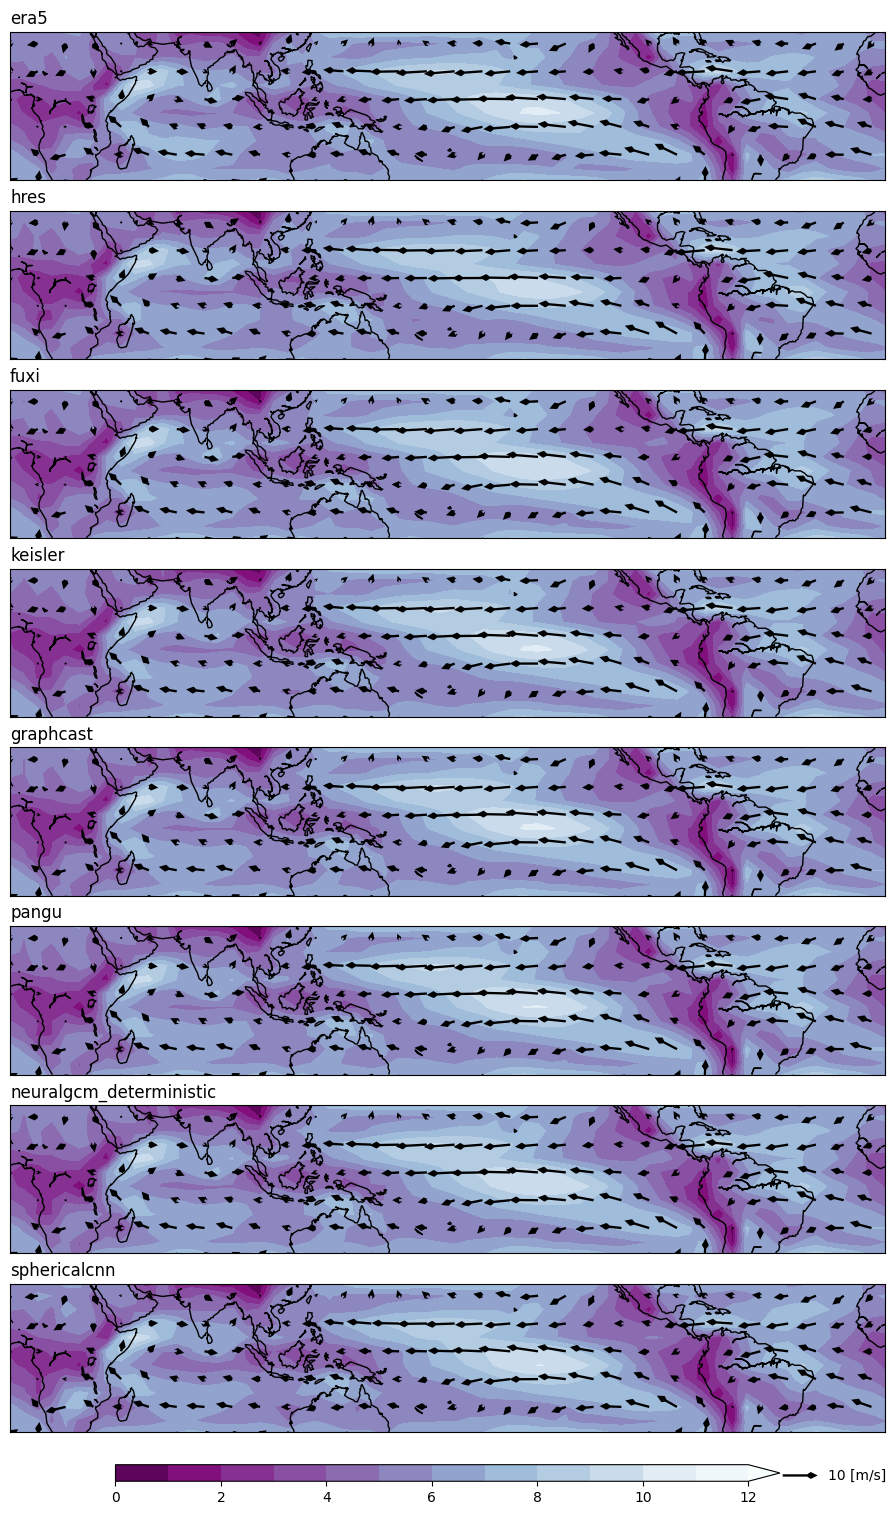

In [7]:
fig, axs = plt.subplots(8,1, figsize=(10,15), sharex=True, layout='constrained')

for ax, od in zip(axs, odirs):
    ds = xr.open_dataset('data/%s/dynamics_850.nc' % od)
    #choose forecast day for forecast models
    if 'prediction_timedelta' in ds.dims:
        ds = ds.sel(prediction_timedelta = np.timedelta64(1, 'D'))

    u = ds['u850']
    v = ds['v850']
    lat = ds.latitude
    lon = ds.longitude
    
    #calculate wind speed
    swnd = cal_wspeed(u, v)
    
    #plotting
    im = map_tropics(ax, swnd.mean('time').transpose(), lat, lon,
                     levels=np.arange(13), extend='max', cmap='BuPu_r')

    #wind vector
    uvector = u.mean('time')
    vvector = v.mean('time')
    
    q = ax.quiver(lon[::2], lat[::2],
                  uvector.transpose()[::2,::2], vvector.transpose()[::2,::2],
                  headlength=3, scale=250, color='black')
    
    ax.set_title(od, loc='left')
    
qk=plt.quiverkey(q, 0.87, 0.02, 10, '10 [m/s]', labelpos='E', coordinates='figure')
plt.colorbar(im, ax=axs, orientation='horizontal', pad=0.02, aspect=40, shrink=0.67)

There are some differences between ERA5 and models, but it is hard to tell.

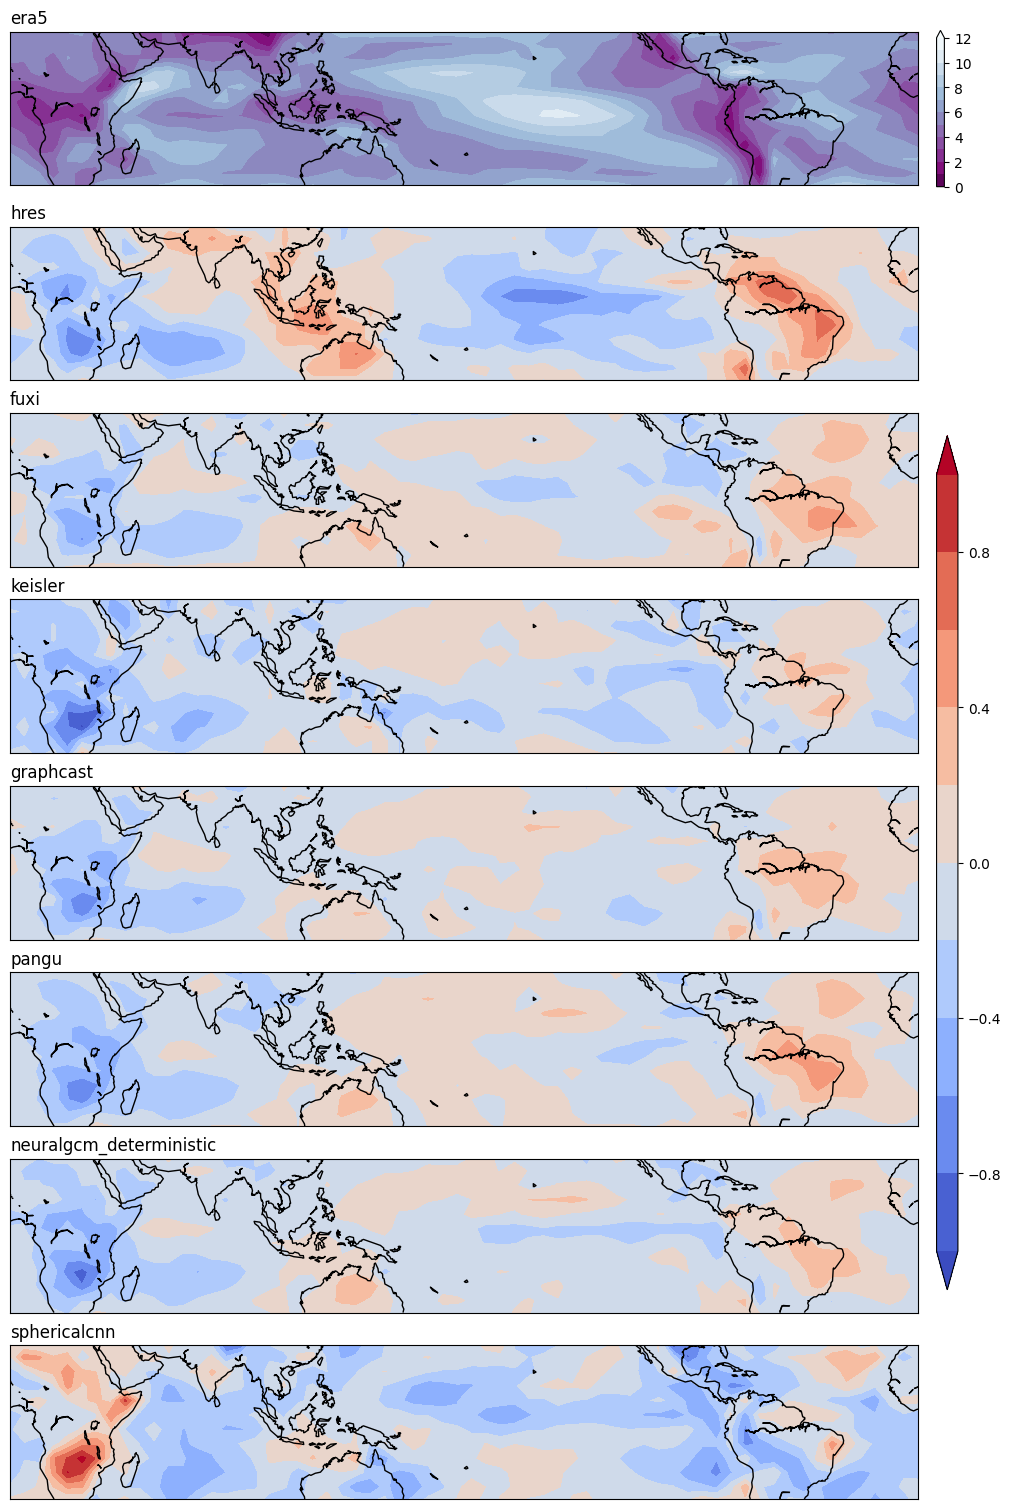

In [8]:
fig, axs = plt.subplots(8,1, figsize=(10,15), sharex=True, layout='constrained')

#ERA5
ds = xr.open_dataset('data/era5/dynamics_850.nc')
swnd_era5 = cal_wspeed(ds['u850'], ds['v850'])
im1 = map_tropics(axs[0], swnd_era5.mean('time').transpose(), lat, lon,
                 levels=np.arange(13), extend='max', cmap='BuPu_r')

axs[0].set_title(odirs[0], loc='left')

for ax, od in zip(axs[1:], odirs[1:]):
    ds = xr.open_dataset('data/%s/dynamics_850.nc' % od)
    #choose forecast day for forecast models
    if 'prediction_timedelta' in ds.dims:
        ds = ds.sel(prediction_timedelta = np.timedelta64(1, 'D'))

    u = ds['u850']
    v = ds['v850']
    lat = ds.latitude
    lon = ds.longitude
    
    #calculate wind speed
    swnd = cal_wspeed(u, v)

    #calculate difference in wind speed between model and era5
    diff = swnd.mean('time') - swnd_era5.mean('time')
    
    #plotting
    im2 = map_tropics(ax, diff.transpose(), lat, lon,
                     levels=np.linspace(-1,1,11), extend='both', cmap='coolwarm')

    ax.set_title(od, loc='left')

plt.colorbar(im1, ax=axs[0], orientation='vertical', pad=0.02)
plt.colorbar(im2, ax=axs[1:], orientation='vertical', pad=0.02, aspect=40, shrink=0.67)

## Exercises

Now it is your turn to get better insights into tropical circulations and differences of them between the models.

1. Open a new jupyter notebook and repeats all the steps.

2. Do we see larger differences between era5 and the models for a longer forecast day?

3. I believe that now you are able to plot wind fields. Can you explain some tropical circulations from your graphs? 